In [ ]:
!uv pip install -q --system numba-cuda==0.4.0
!pip install --upgrade numba

In [ ]:
import numba
import numba.cuda as cuda
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
import matplotlib.pyplot as plt
import numpy as np
import math, time

Image size: (604, 900, 3), value range: [0.0, 255.0]


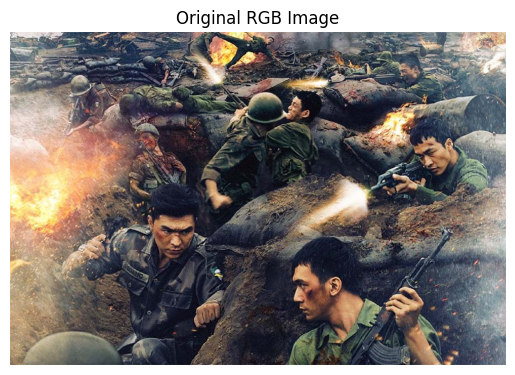

In [ ]:
img_path = "/content/fl.jpg"
img = plt.imread(img_path)

print(f"Image size: {img.shape}, value range: [{img.min():.1f}, {img.max():.1f}]")

plt.imshow(img)
plt.title("Original RGB Image")
plt.axis("off")
plt.show()

In [ ]:
gaussian_kernel = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
], dtype=np.float32)
gaussian_kernel /= gaussian_kernel.sum()


CPU (gray) time: 33.4130s


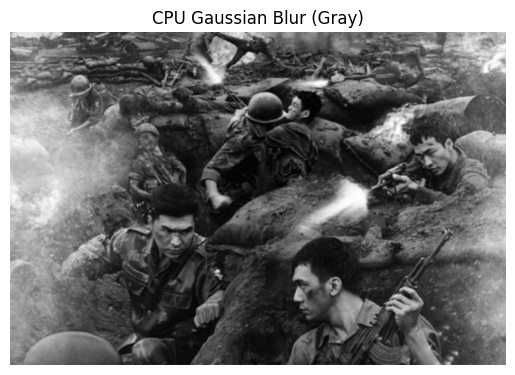

In [ ]:
def gaussian_blur_cpu_gray(src, kernel):
    k = kernel.shape[0]
    r = k // 2
    dst = np.zeros_like(src)
    for i in range(src.shape[0]):
        for j in range(src.shape[1]):
            acc = 0.0
            for a in range(-r, r + 1):
                for b in range(-r, r + 1):
                    x = min(max(i + a, 0), src.shape[0] - 1)
                    y = min(max(j + b, 0), src.shape[1] - 1)
                    acc += src[x, y] * kernel[a + r, b + r]
            dst[i, j] = acc
    return dst

gray_img = np.mean(img, axis=2).astype(np.float32)

# grayscale
start_cpu = time.time()
blurred_cpu_gray = gaussian_blur_cpu_gray(gray_img, gaussian_kernel)
end_cpu = time.time()
cpu_time = end_cpu - start_cpu
print(f"\nCPU (gray) time: {cpu_time:.4f}s")

plt.imshow(np.clip(blurred_cpu_gray / 255, 0, 1), cmap='gray')
plt.title("CPU Gaussian Blur (Gray)")
plt.axis("off")
plt.show()


Grid: (38, 57), Block: (16, 16)
GPU time (grayscale, no shared): 0.2472s


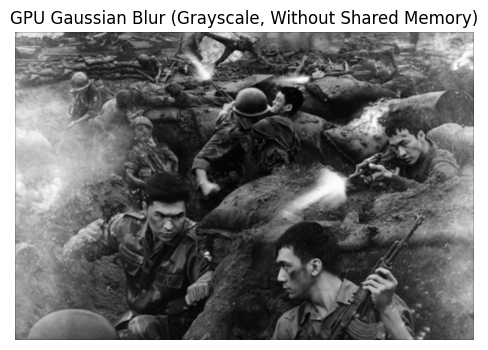

In [ ]:
# GPU without shared
@cuda.jit
def gaussianblur2D_gray(src, dst, kernel):
    x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    y = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y

    if x >= src.shape[0] or y >= src.shape[1]:
        return

    k_half_h = kernel.shape[0] // 2
    k_half_w = kernel.shape[1] // 2
    acc = 0.0

    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            xi = x + i - k_half_h
            yj = y + j - k_half_w
            if 0 <= xi < src.shape[0] and 0 <= yj < src.shape[1]:
                acc += src[xi, yj] * kernel[i, j]

    dst[x, y] = acc

src_gpu = cuda.to_device(gray_img)
kernel_gpu = cuda.to_device(gaussian_kernel)
dst_gpu = cuda.device_array_like(gray_img)

height, width = gray_img.shape
block_size = (16, 16)
grid_size = (
    (height + block_size[0] - 1) // block_size[0],
    (width + block_size[1] - 1) // block_size[1]
)
print(f"Grid: {grid_size}, Block: {block_size}")

# run kernel and measure time
start_gpu = time.time()
gaussianblur2D_gray[grid_size, block_size](src_gpu, dst_gpu, kernel_gpu)
cuda.synchronize()
end_gpu = time.time()

gpu_time = end_gpu - start_gpu
print(f"GPU time (grayscale, no shared): {gpu_time:.4f}s")

blurred_gpu = dst_gpu.copy_to_host()

plt.figure(figsize=(6,4))
plt.imshow(np.clip(blurred_gpu, 0, 255).astype(np.uint8), cmap="gray")
plt.title("GPU Gaussian Blur (Grayscale, Without Shared Memory)")
plt.axis("off")
plt.show()

GPU time (grayscale, with shared memory): 0.1708s


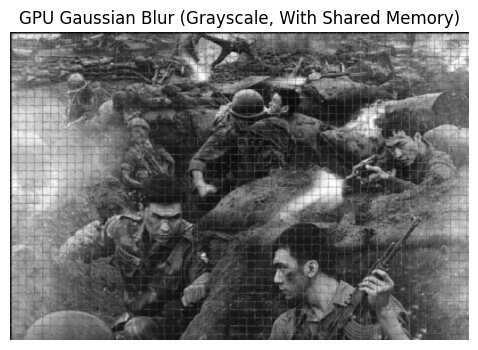


 Speedup (shared vs no-shared): 1.45x faster


In [ ]:
# GPU with shared
@cuda.jit
def gaussianblur2D_shared_gray(src, dst, kernel):
    x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    y = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    r_k = kernel.shape[0] // 2
    block_size = cuda.blockDim.x
    tile_size = block_size + 2 * r_k

    tile = cuda.shared.array(shape=(40, 40), dtype=float32)

    gx = x - r_k
    gy = y - r_k

    if 0 <= gx < src.shape[0] and 0 <= gy < src.shape[1]:
        tile[tx + r_k, ty + r_k] = src[gx, gy]
    else:
        tile[tx + r_k, ty + r_k] = 0.0

    cuda.syncthreads()

    #  compute blur for valid output pixels
    if x < dst.shape[0] and y < dst.shape[1]:
        acc = 0.0
        for i in range(-r_k, r_k + 1):
            for j in range(-r_k, r_k + 1):
                acc += tile[tx + r_k + i, ty + r_k + j] * kernel[i + r_k, j + r_k]
        dst[x, y] = acc


tile_size = 16
height, width = gray_img.shape

block_size = (tile_size, tile_size)
grid_size = (
    (height + tile_size - 1) // tile_size,
    (width + tile_size - 1) // tile_size
)

src_gpu = cuda.to_device(gray_img)
dst_gpu_shared = cuda.device_array_like(gray_img)
kernel_gpu = cuda.to_device(gaussian_kernel)

start_gpu_shared = time.time()
gaussianblur2D_shared_gray[grid_size, block_size](src_gpu, dst_gpu_shared, kernel_gpu)
cuda.synchronize()
end_gpu_shared = time.time()

gpu_shared_time = end_gpu_shared - start_gpu_shared
print(f"GPU time (grayscale, with shared memory): {gpu_shared_time:.4f}s")

blurred_gpu_shared = dst_gpu_shared.copy_to_host()

plt.figure(figsize=(6,4))
plt.imshow(np.clip(blurred_gpu_shared, 0, 255).astype(np.uint8), cmap="gray")
plt.title("GPU Gaussian Blur (Grayscale, With Shared Memory)")
plt.axis("off")
plt.show()

# Compare
try:
    print(f"\n Speedup (shared vs no-shared): {gpu_time / gpu_shared_time:.2f}x faster")
except NameError:
    print("\nNote: Define `gpu_time` from your previous no-shared kernel cell to compare speed.")

In [ ]:
block_sizes = [8, 16, 24, 32]

times_no_shared = []
times_shared = []

height, width = gray_img.shape

for block_size_val in block_sizes:
    block_size = (block_size_val, block_size_val)
    grid_size_no_shared = (
        (height + block_size[0] - 1) // block_size[0],
        (width + block_size[1] - 1) // block_size[1]
    )
    grid_size_shared = (
        (height + (block_size_val - 6) - 1) // (block_size_val - 6),
        (width + (block_size_val - 6) - 1) // (block_size_val - 6)
    )

    # Run no-shared kernel
    src_gpu = cuda.to_device(gray_img)
    dst_gpu = cuda.device_array_like(gray_img)
    kernel_gpu = cuda.to_device(gaussian_kernel)

    start_gpu = time.time()
    gaussianblur2D_gray[grid_size_no_shared, block_size](src_gpu, dst_gpu, kernel_gpu)
    cuda.synchronize()
    end_gpu = time.time()
    times_no_shared.append(end_gpu - start_gpu)

    # Run shared kernel
    src_gpu = cuda.to_device(gray_img)
    dst_gpu_shared = cuda.device_array_like(gray_img)
    kernel_gpu = cuda.to_device(gaussian_kernel)

    start_gpu_shared = time.time()
    gaussianblur2D_shared_gray[grid_size_shared, block_size](src_gpu, dst_gpu_shared, kernel_gpu)
    cuda.synchronize()
    end_gpu_shared = time.time()
    times_shared.append(end_gpu_shared - start_gpu_shared)

    print(f"Completed block size {block_size_val}x{block_size_val}")

Completed block size 8x8
Completed block size 16x16
Completed block size 24x24
Completed block size 32x32


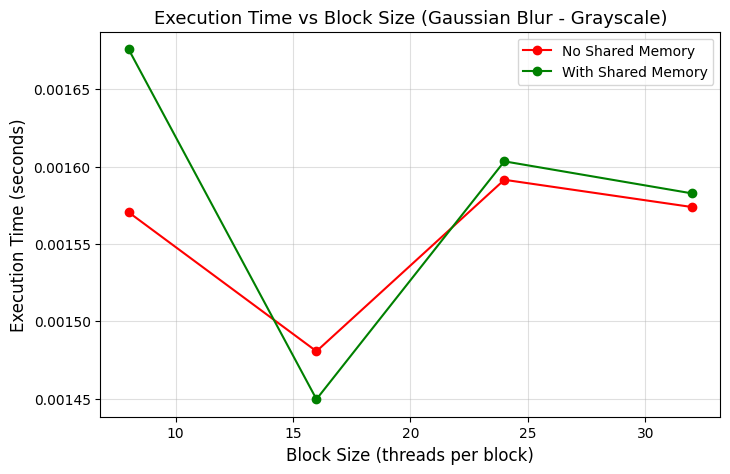

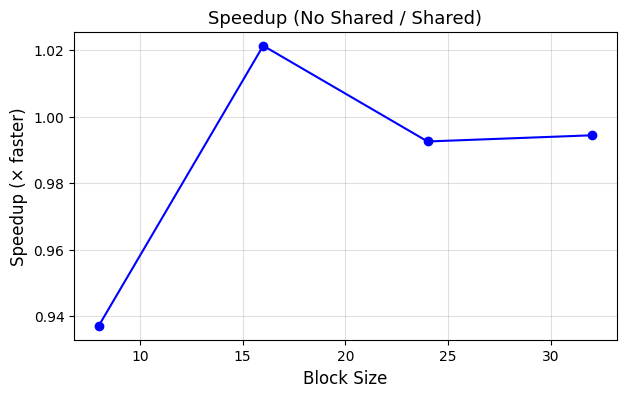

Speedup Summary:
Block 8x8: no_shared=0.0016s, shared=0.0017s → 0.94× faster with shared memory
Block 16x16: no_shared=0.0015s, shared=0.0014s → 1.02× faster with shared memory
Block 24x24: no_shared=0.0016s, shared=0.0016s → 0.99× faster with shared memory
Block 32x32: no_shared=0.0016s, shared=0.0016s → 0.99× faster with shared memory


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(block_sizes, times_no_shared, marker='o', color='red', label='No Shared Memory')
plt.plot(block_sizes, times_shared, marker='o', color='green', label='With Shared Memory')
plt.title('Execution Time vs Block Size (Gaussian Blur - Grayscale)', fontsize=13)
plt.xlabel('Block Size (threads per block)', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

speedups = np.array(times_no_shared) / np.array(times_shared)

plt.figure(figsize=(7,4))
plt.plot(block_sizes, speedups, marker='o', color='blue')
plt.title('Speedup (No Shared / Shared)', fontsize=13)
plt.xlabel('Block Size', fontsize=12)
plt.ylabel('Speedup (× faster)', fontsize=12)
plt.grid(True, alpha=0.4)
plt.show()

print("Speedup Summary:")
for bs, t_no, t_sh, sp in zip(block_sizes, times_no_shared, times_shared, speedups):
    print(f"Block {bs}x{bs}: no_shared={t_no:.4f}s, shared={t_sh:.4f}s → {sp:.2f}× faster with shared memory")